# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru
- **Поддержка CUDA**: А.Е.Григорьева admin@linkennt.ru
- **Ревизия**: 8

- **Другие ревизии**: [ссылка](https://disk.yandex.ru/d/aZozDpBlzh_z1A)
<!-- please do not append text into this block -->

In [ ]:
# Go up

import os

os.chdir("..")

- Добавлено 2x больше эпох на датасетах, где был плохой перфоманс: (1, 2, 5, 7, 8)
- К целевой переменной примешивается на этапе обучения шум с амплитудой ~0,03 дисперсии; стабильно распределённый шум с варьированием $\alpha$ от 1 до 2; сравнивается с обучением без шума

## Setup

In [2]:
from cgtnnlib.constants import LEARNING_RATE, RANDOM_STATE
import cgtnnlib.training as tr
import cgtnnlib.datasets as ds
from cgtnnlib.NoiseGenerator import (
    target_dispersion_scaled_noise,
    stable_noise,
    no_noise_generator,
)


iterations = 10
epochs = 10
pp = [0.0, 0.5, 0.9]

double_epochs_datasets = [
    ds.datasets[0],  # 1
    ds.datasets[1],  # 2
    ds.datasets[4],  # 5
    ds.datasets[6],  # 7
    ds.datasets[7],  # 8
]

# datasets = ds.datasets

datasets = [
    ds.datasets[0],  # 1
    ds.datasets["StudentPerformanceFactors"],  # 3
    ds.datasets["allhyper"],  # 4
    ds.datasets["wine_quality"],  # 6
]

ng_makers = [
    lambda _: no_noise_generator,
    lambda dataset: target_dispersion_scaled_noise(
        dataset=dataset,
        factor=0.03,
        random_seed=RANDOM_STATE + 1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.12,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.25,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.5,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=1.75,
        beta=1,
    ),
    lambda dataset: stable_noise(
        dataset=dataset,
        factor=0.03,
        alpha=2.0,
        beta=1,
    ),
]

TORCH_DEVICE is cpu


In [37]:
ng_makers[0](datasets[0]).next_sample()

0


## Генерация стабильного шума

Используется алгоритм Chambers-Mallows-Stuck (CMS) [1]; в [2] алгоритм дан в прямом виде. Реализация в файле *cgtnnlib/NoiseGenerator.py*.

In [38]:
ng = stable_noise(dataset=datasets[0], factor=0.03, alpha=1, beta=0.0)

print(ng.name)
[ng.next_sample() for _ in range(10)]

Stable1A1B0.0F0.03


[-0.005279588669174442,
 0.0031930501306324218,
 -0.035075205006525584,
 0.006596254315176364,
 -0.007616876775682892,
 -0.0014256312065177182,
 0.0023231485608523,
 -0.027976844253626627,
 -0.1325666989224497,
 0.0003374316519907252]

In [39]:
dataset = ds.datasets["StudentPerformanceFactors"]
dataset.data.df[dataset.target].std() ** 2

15.215720060424232

## Training

- both take ~5m 06s to train 10 iterations
- both on both noises: about ~10m

<hr>

- `ds.datasets['StudentPerformanceFactors']` takes ~2m 30s to train 10 iterations
- `ds.datasets['wine_quality']` takes ~2m 36s to train 10 iterations

<hr>

- `ds.datasets['allhyper']` takes ~36m to train on all noise generators

In [2]:
for i, dataset in enumerate(datasets):
    for ng_maker in ng_makers:
        for p in pp:
            noise_generator = ng_maker(dataset)
            for iteration in range(iterations):
                tr.create_and_train_model(
                    dataset,
                    epochs * 2 if dataset in double_epochs_datasets else epochs,
                    learning_rate=LEARNING_RATE,
                    dry_run=False,
                    p=p,
                    iteration=iteration,
                    noise_generator=noise_generator,
                    must_not_exist=True,
                )

File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N1.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N2.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N3.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N4.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N5.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N6.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N7.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N8.pth. Skipping training.
File already exists at pth//cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N9.pth. Skipping training.
File alrea

```python
IndexError: Target 106 is out of bounds.

        TORCH_CHECK_INDEX(
            cur_target >= 0 && cur_target < n_classes,
            "Target ",
            cur_target,
            " is out of bounds.");
```

https://github.com/pytorch/pytorch/blob/4106aa33eb2946bf67f4ffd2ad9f2dcb52ed2384/aten/src/ATen/native/LossNLL.cpp#L192

## Evaluation & Analysis

Выполнить эту ячейку для eval или следующую для loss.
Чтобы всё отрисовалось, нужно запустить два раза

In [ ]:
## Analysis

import json

import pandas as pd

import matplotlib.pyplot as plt

from cgtnnlib.LearningTask import is_classification_task
from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt
from cgtnnlib.constants import NOISE_FACTORS
from cgtnnlib.evaluate import eval_report_at_path
from cgtnnlib.nn.AugmentedReLUNetwork import AugmentedReLUNetwork


def read_json(path: str) -> dict:
    with open(path) as file:
        return json.load(file)


def summarize_series_list(series_list: list[pd.Series]):
    df = pd.DataFrame(series_list).T

    summary_df = pd.DataFrame(
        {
            0.25: df.quantile(0.25, axis=1),
            0.75: df.quantile(0.75, axis=1),
            "mean": df.mean(axis=1),
        }
    )

    return summary_df


def make_ax_drawer(
    read_json,
    dataset,
    ng_maker,
    p,
):
    noise_generator = ng_maker(dataset)
    prefix = (
        f"cgtnn-{dataset.number}Y-AugmentedReLUNetwork"
        + f"-g{noise_generator.name}-P{p}_"
    )

    def report_path(n):
        return f"pth/{prefix}N{n}.json"

    def model_path(n):
        return f"pth/{prefix}N{n}.pth"

    def read_eval_from_iteration(n) -> pd.DataFrame:
        path = report_path(n)
        eval_report_at_path(
            report_path=path,
            model_path=model_path(n),
            constructor=AugmentedReLUNetwork,
            dataset=dataset,
            p=p,
        )
        print("read_eval_from_iteration", path, n)
        return pd.DataFrame(read_json(path)["eval"])

    def read_loss_from_iteration(n) -> pd.DataFrame:
        path = report_path(n)
        json = read_json(path)
        return pd.DataFrame(json["loss"])

    if is_classification_task(dataset.learning_task):
        metric = "roc_auc"
    else:
        metric = "mse"

    files = [read_eval_from_iteration(n) for n in range(iterations)]

    print(report_path(0))

    curve = summarize_series_list([file[metric] for file in files])

    def draw_ax(ax):
        plot_deviant_curves_on_ax_or_plt(
            ax_or_plt=ax,
            models=[
                {
                    "curve": curve,
                    "color": "purple",
                    "label": "Среднее",
                    "quantiles_color": "pink",
                    "quantiles_label": "Квартили 0,25; 0,75",
                }
            ],
            X=NOISE_FACTORS,
            title="\n".join(
                [
                    f"{noise_generator.name}, p = {p}",
                ]
            ),
            xlabel="Шум на входе",
            ylabel=metric,
            quantiles_alpha=0.5,
        )

    return draw_ax


ax_drawers = [
    [
        [make_ax_drawer(read_json, dataset, ng_maker, p) for p in pp]
        for ng_maker in ng_makers
    ]
    for dataset in datasets
]

Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json 0
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N1.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N1.json 1
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N2.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N2.json 2
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N3.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N3.json 3
Report found at pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N4.json. Loading...
Report loaded.
Skipping evaluation.
read_eval_from_iteration pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-

In [30]:
## Analysis

import json

import pandas as pd

import matplotlib.pyplot as plt

from cgtnnlib.LearningTask import is_classification_task
from cgtnnlib.analyze import plot_deviant_curves_on_ax_or_plt
from cgtnnlib.constants import NOISE_FACTORS
from cgtnnlib.evaluate import eval_report_at_path
from cgtnnlib.nn.AugmentedReLUNetwork import AugmentedReLUNetwork


def read_json(path: str) -> dict:
    with open(path) as file:
        return json.load(file)


def summarize_series_list(series_list: list[pd.Series]):
    df = pd.DataFrame(series_list).T

    summary_df = pd.DataFrame(
        {
            0.25: df.quantile(0.25, axis=1),
            0.75: df.quantile(0.75, axis=1),
            "mean": df.mean(axis=1),
        }
    )

    return summary_df


def make_ax_drawer(
    read_json,
    dataset,
    ng_maker,
    p,
):
    noise_generator = ng_maker(dataset)
    prefix = (
        f"cgtnn-{dataset.number}Y-AugmentedReLUNetwork"
        + f"-g{noise_generator.name}-P{p}_"
    )

    def report_path(n):
        return f"pth/{prefix}N{n}.json"

    def model_path(n):
        return f"pth/{prefix}N{n}.pth"

    def read_eval_from_iteration(n) -> pd.DataFrame:
        path = report_path(n)
        eval_report_at_path(
            report_path=path,
            model_path=model_path(n),
            constructor=AugmentedReLUNetwork,
            dataset=dataset,
            p=p,
        )
        print("read_eval_from_iteration", path, n)
        return pd.DataFrame(read_json(path)["eval"])

    def read_loss_from_iteration(n) -> pd.DataFrame:
        path = report_path(n)
        json = read_json(path)
        return pd.DataFrame({"loss": json["loss"]})

    metric = "loss"

    files = [read_loss_from_iteration(n) for n in range(iterations)]

    print(f"Processing {report_path(0)}...")

    curve = summarize_series_list([file[metric] for file in files])

    def draw_ax(ax):
        plot_deviant_curves_on_ax_or_plt(
            ax_or_plt=ax,
            models=[
                {
                    "curve": curve,
                    "color": "purple",
                    "label": "Среднее",
                    "quantiles_color": "pink",
                    "quantiles_label": "Квартили 0,25; 0,75",
                }
            ],
            X=curve.index,
            title="\n".join(
                [
                    f"{noise_generator.name}, p = {p}",
                ]
            ),
            xlabel="Итерация",
            ylabel=metric,
            quantiles_alpha=0.5,
        )

    return draw_ax


ax_drawers = [
    [
        [make_ax_drawer(read_json, dataset, ng_maker, p) for p in pp]
        for ng_maker in ng_makers
    ]
    for dataset in datasets
]

print(ax_drawers)

Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.0_N0.json...
Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.5_N0.json...
Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gNoNoise-P0.9_N0.json...
Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.0_N0.json...
Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.5_N0.json...
Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gTDS1-P0.9_N0.json...
Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.0_N0.json...
Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.5_N0.json...
Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1B1F0.03-P0.9_N0.json...
Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.0_N0.json...
Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.5_N0.json...
Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.12B1F0.03-P0.9_N0.json...
Processing pth/cgtnn-1Y-AugmentedReLUNetwork-gStable1A1.25B1F0.03-P0.0_N0.json...
Processing pth/cgtnn-1Y-

In [31]:
(nrows, ncols) = (
    len(ax_drawers[0]),
    len(ax_drawers[0][0]),
)

(nrows, ncols)

(8, 3)

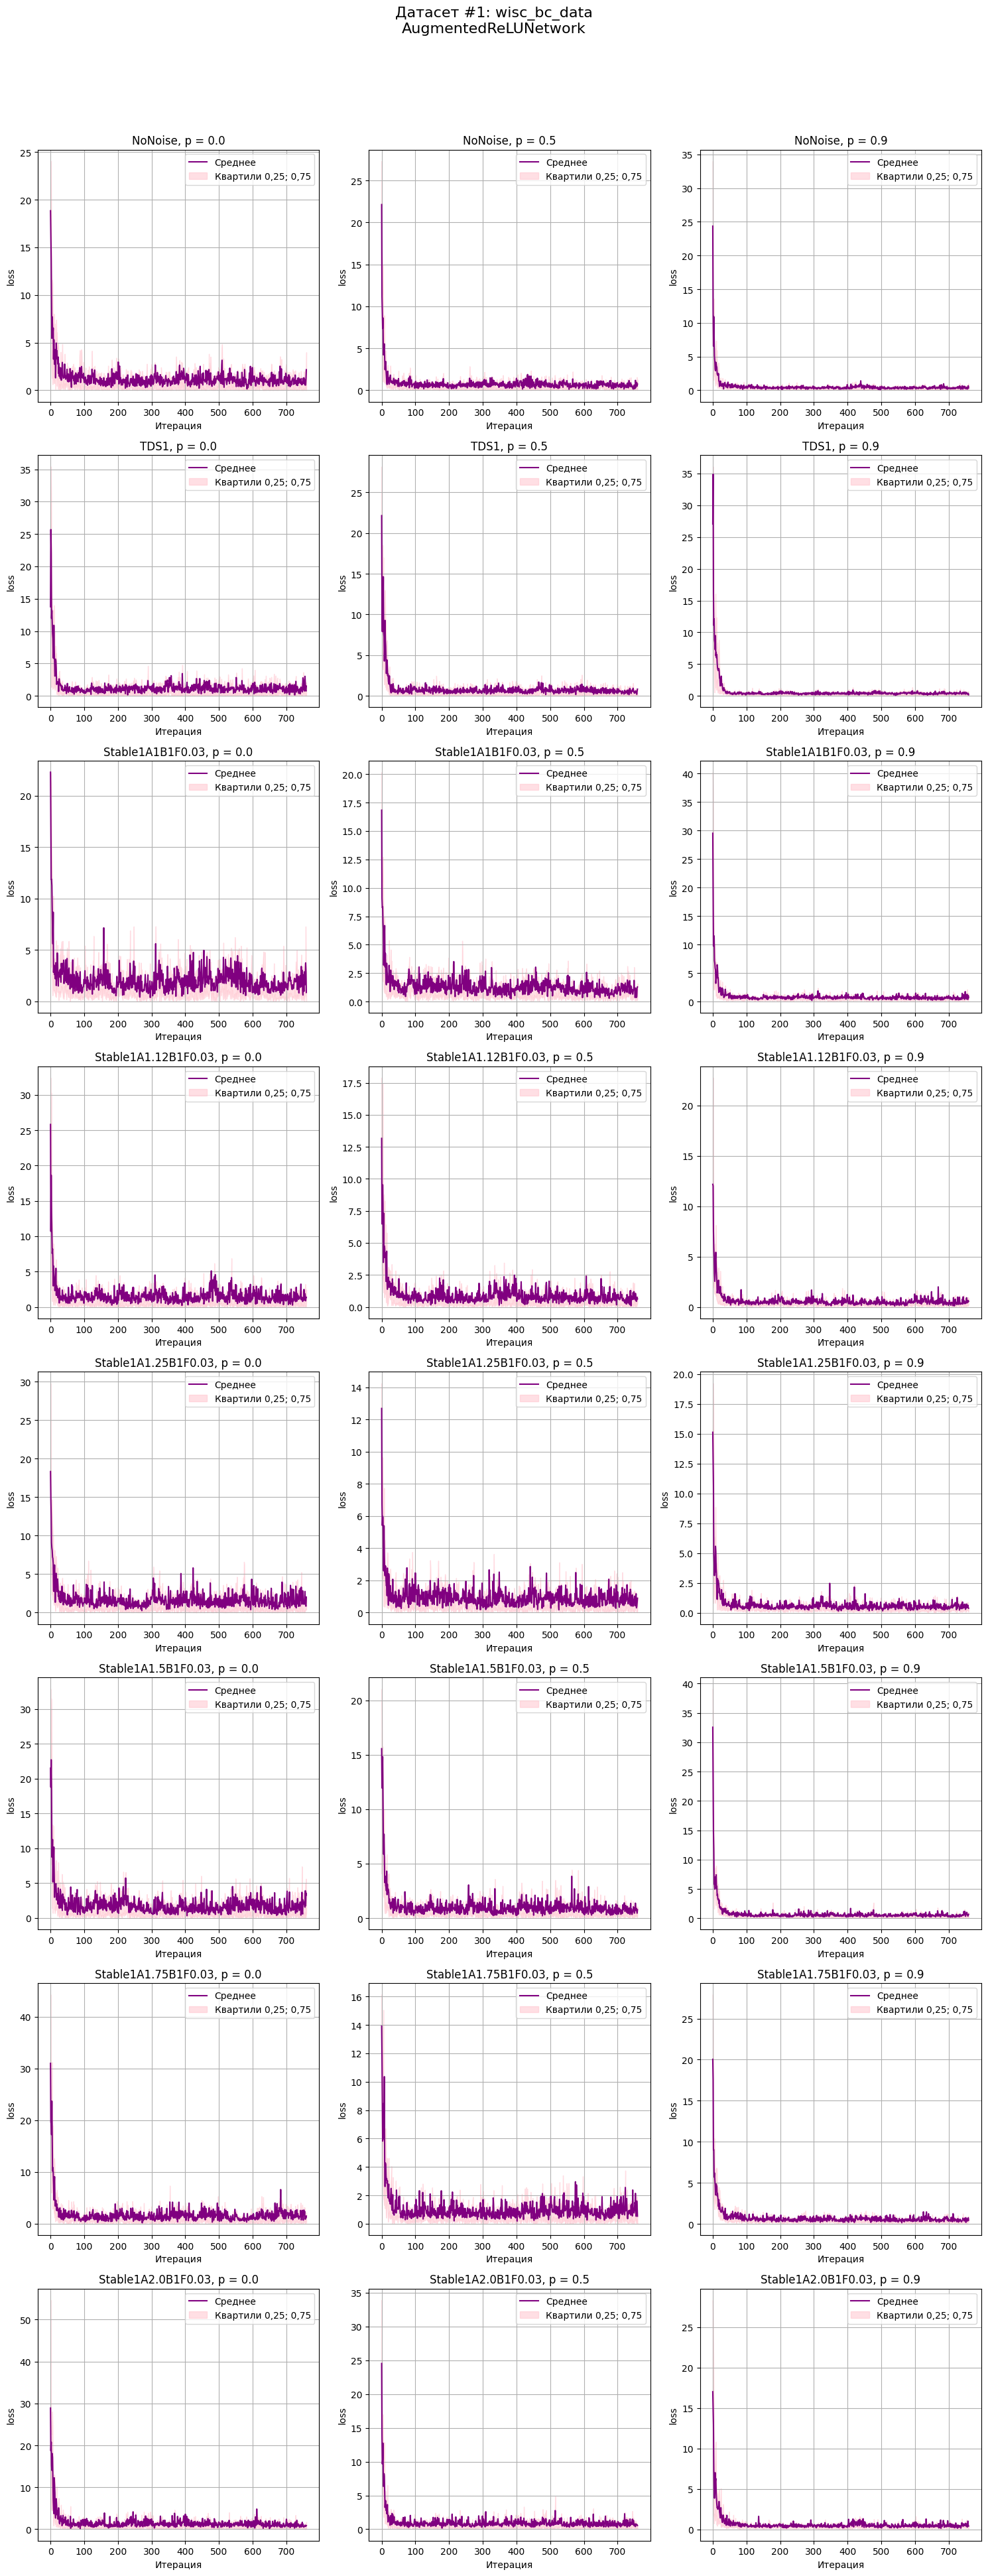

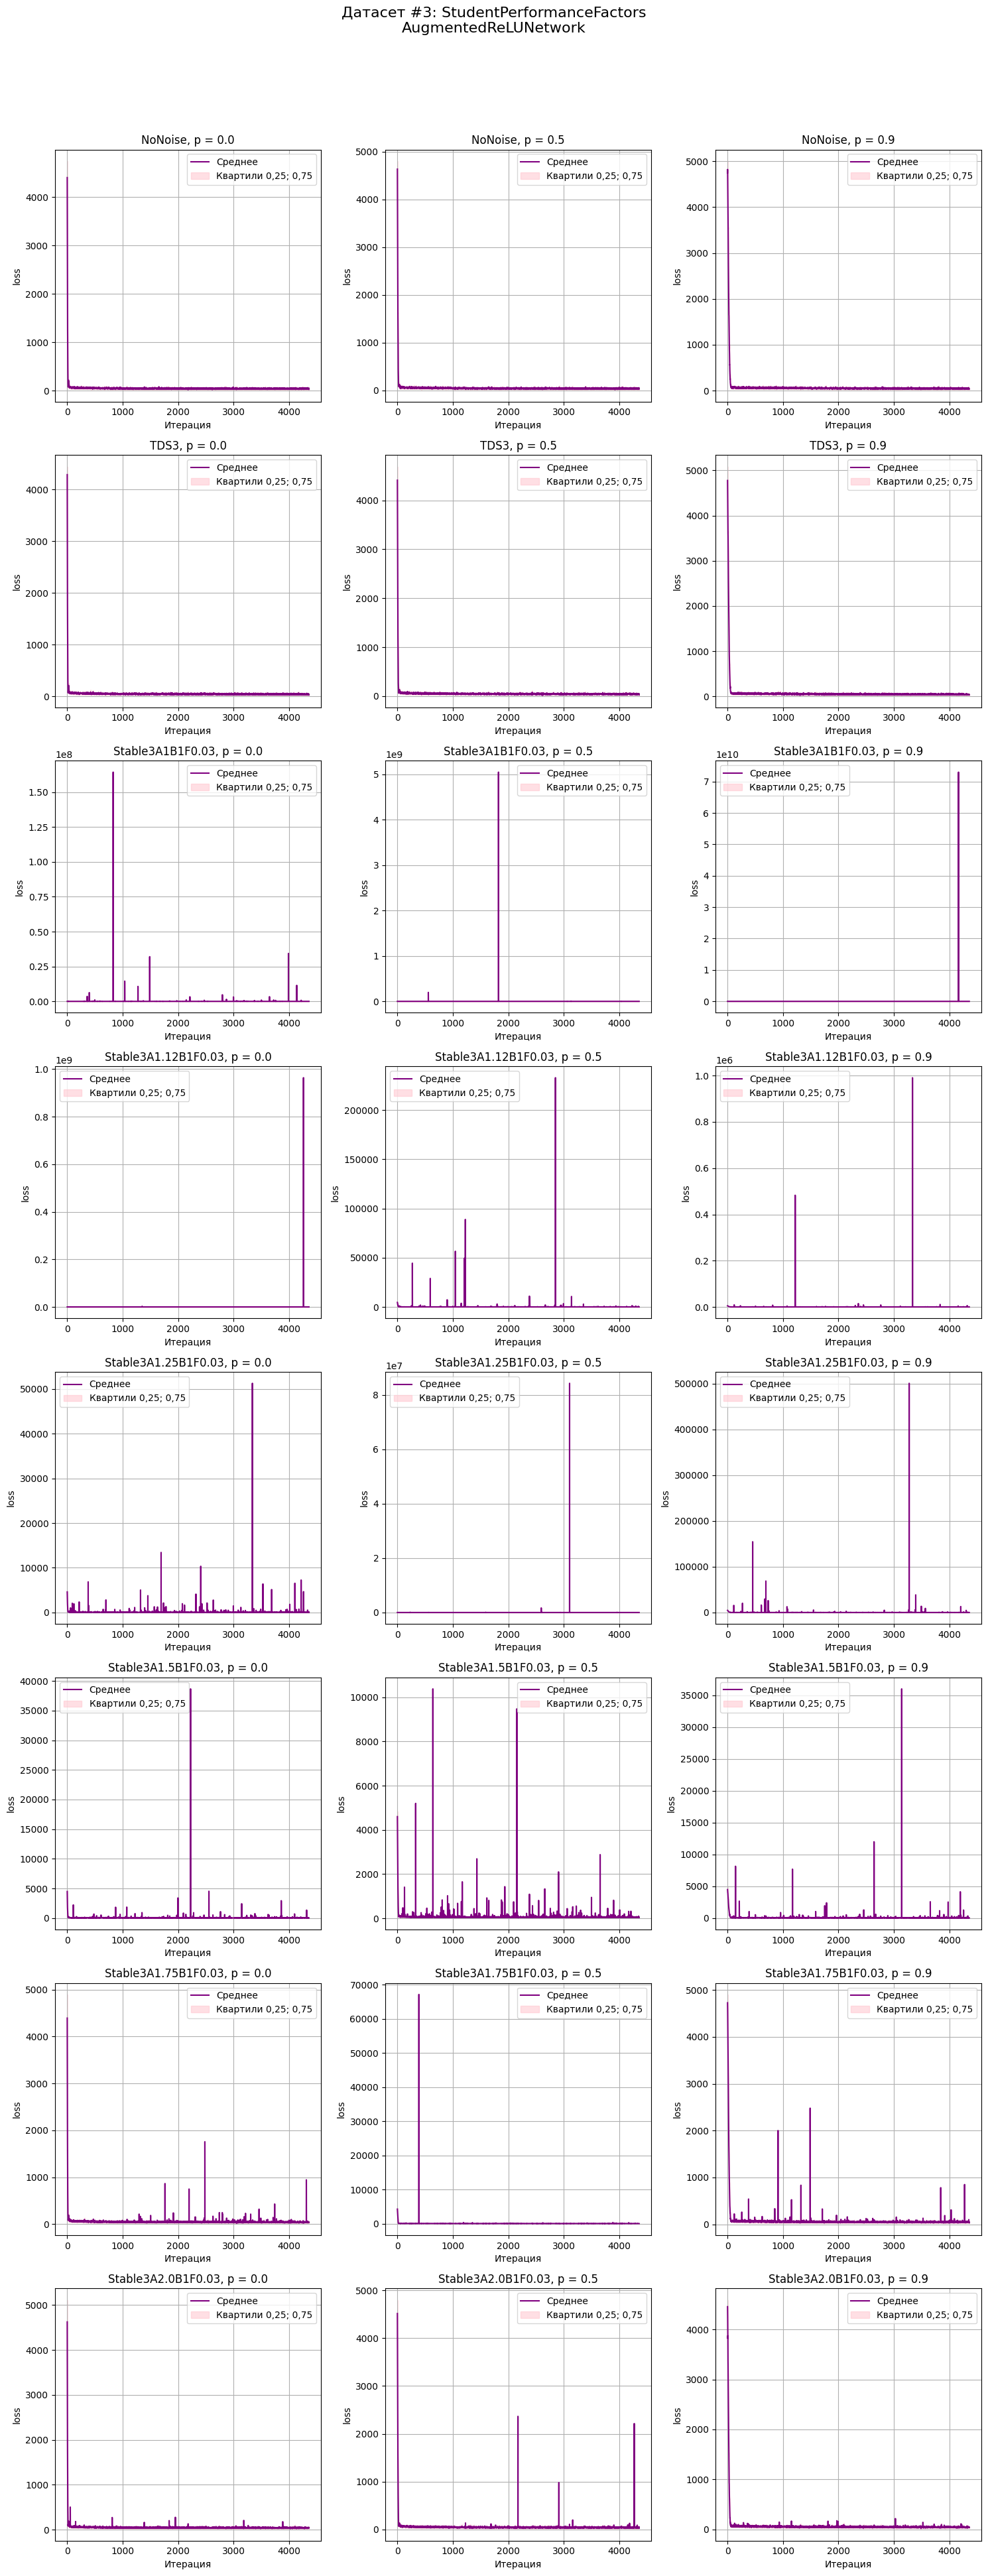

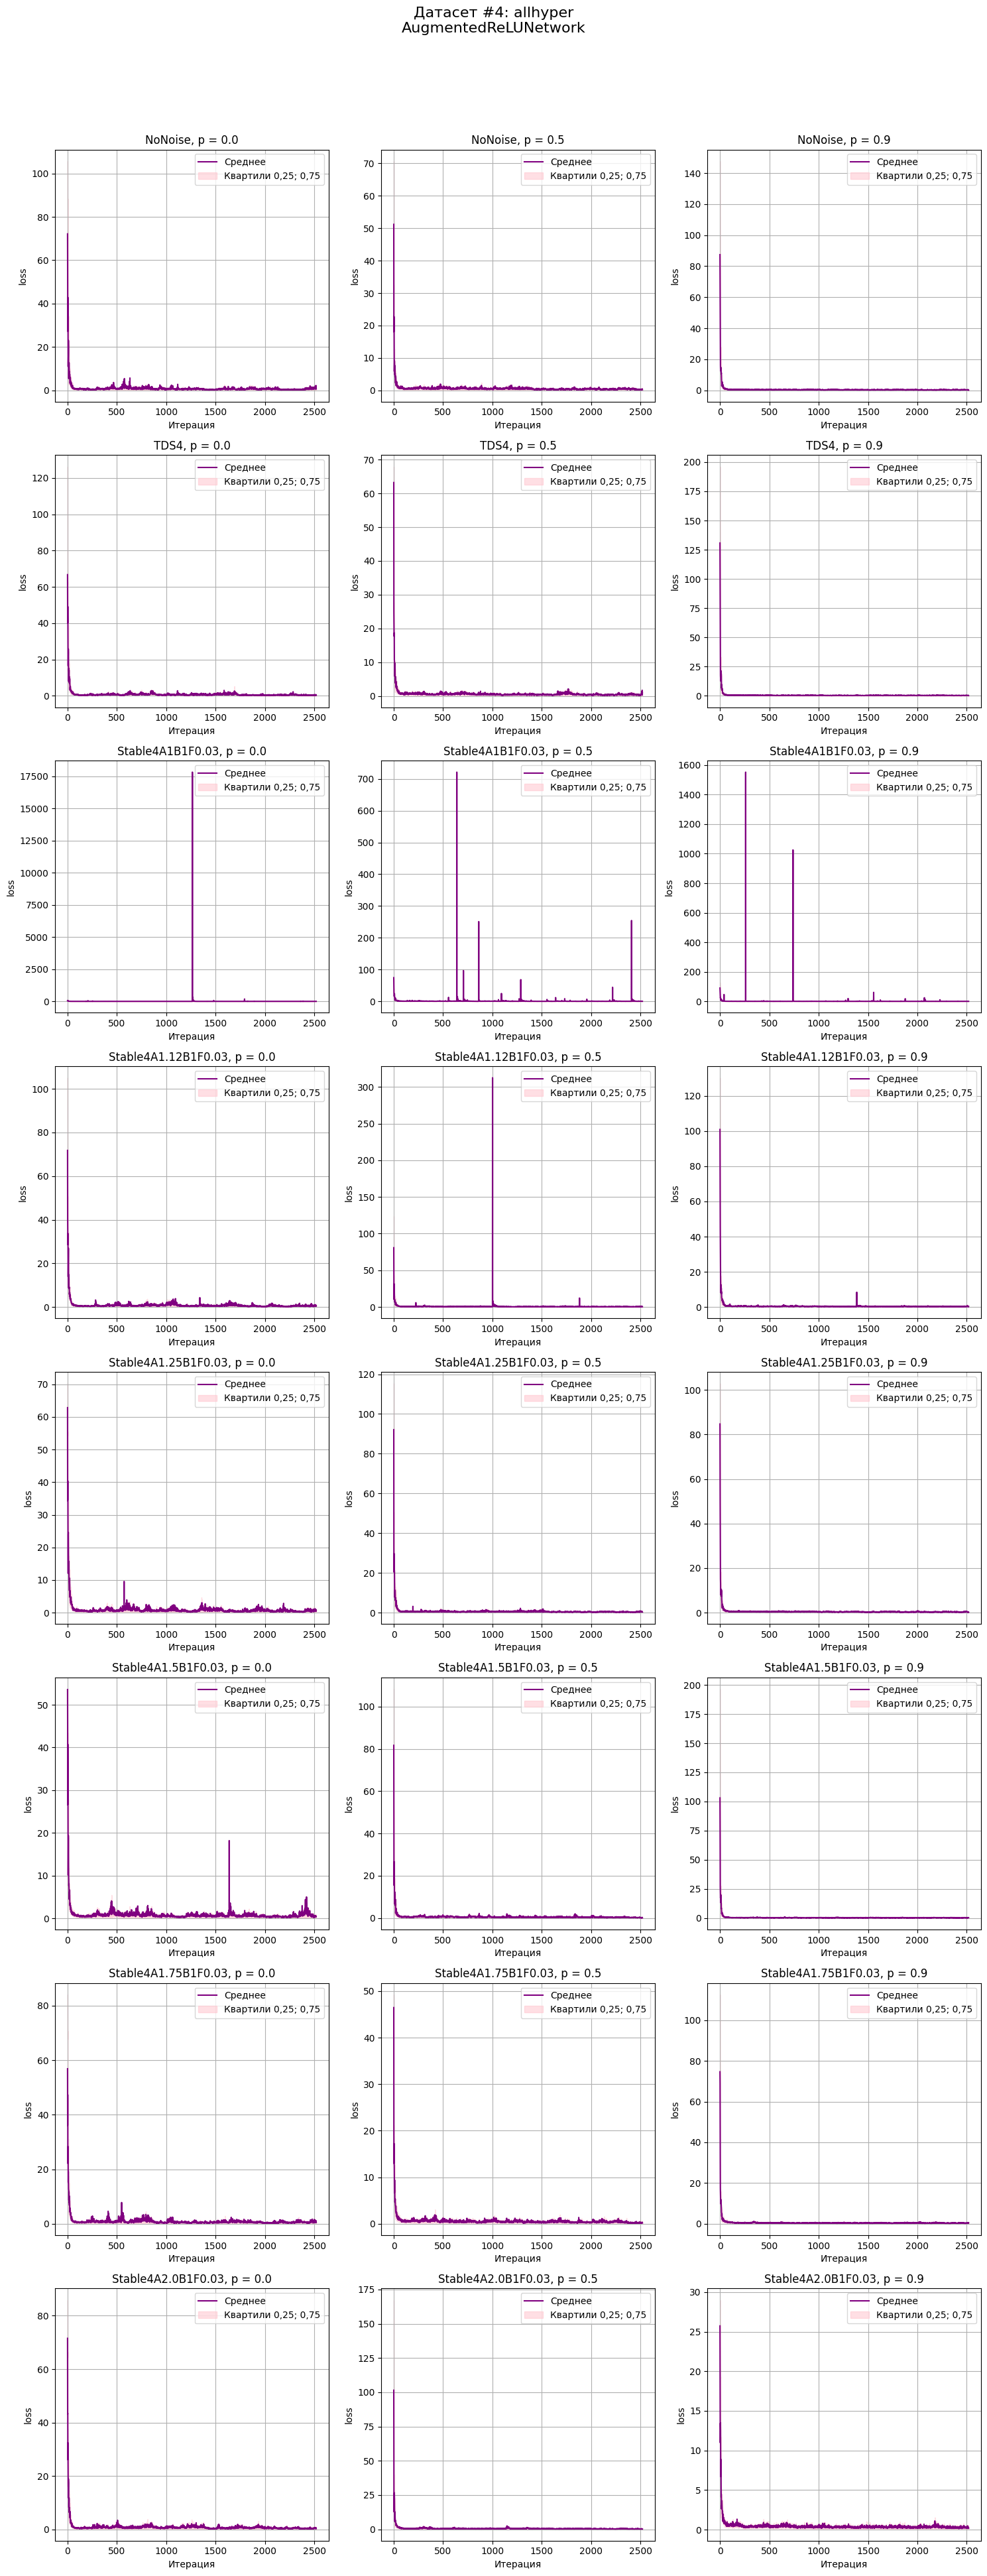

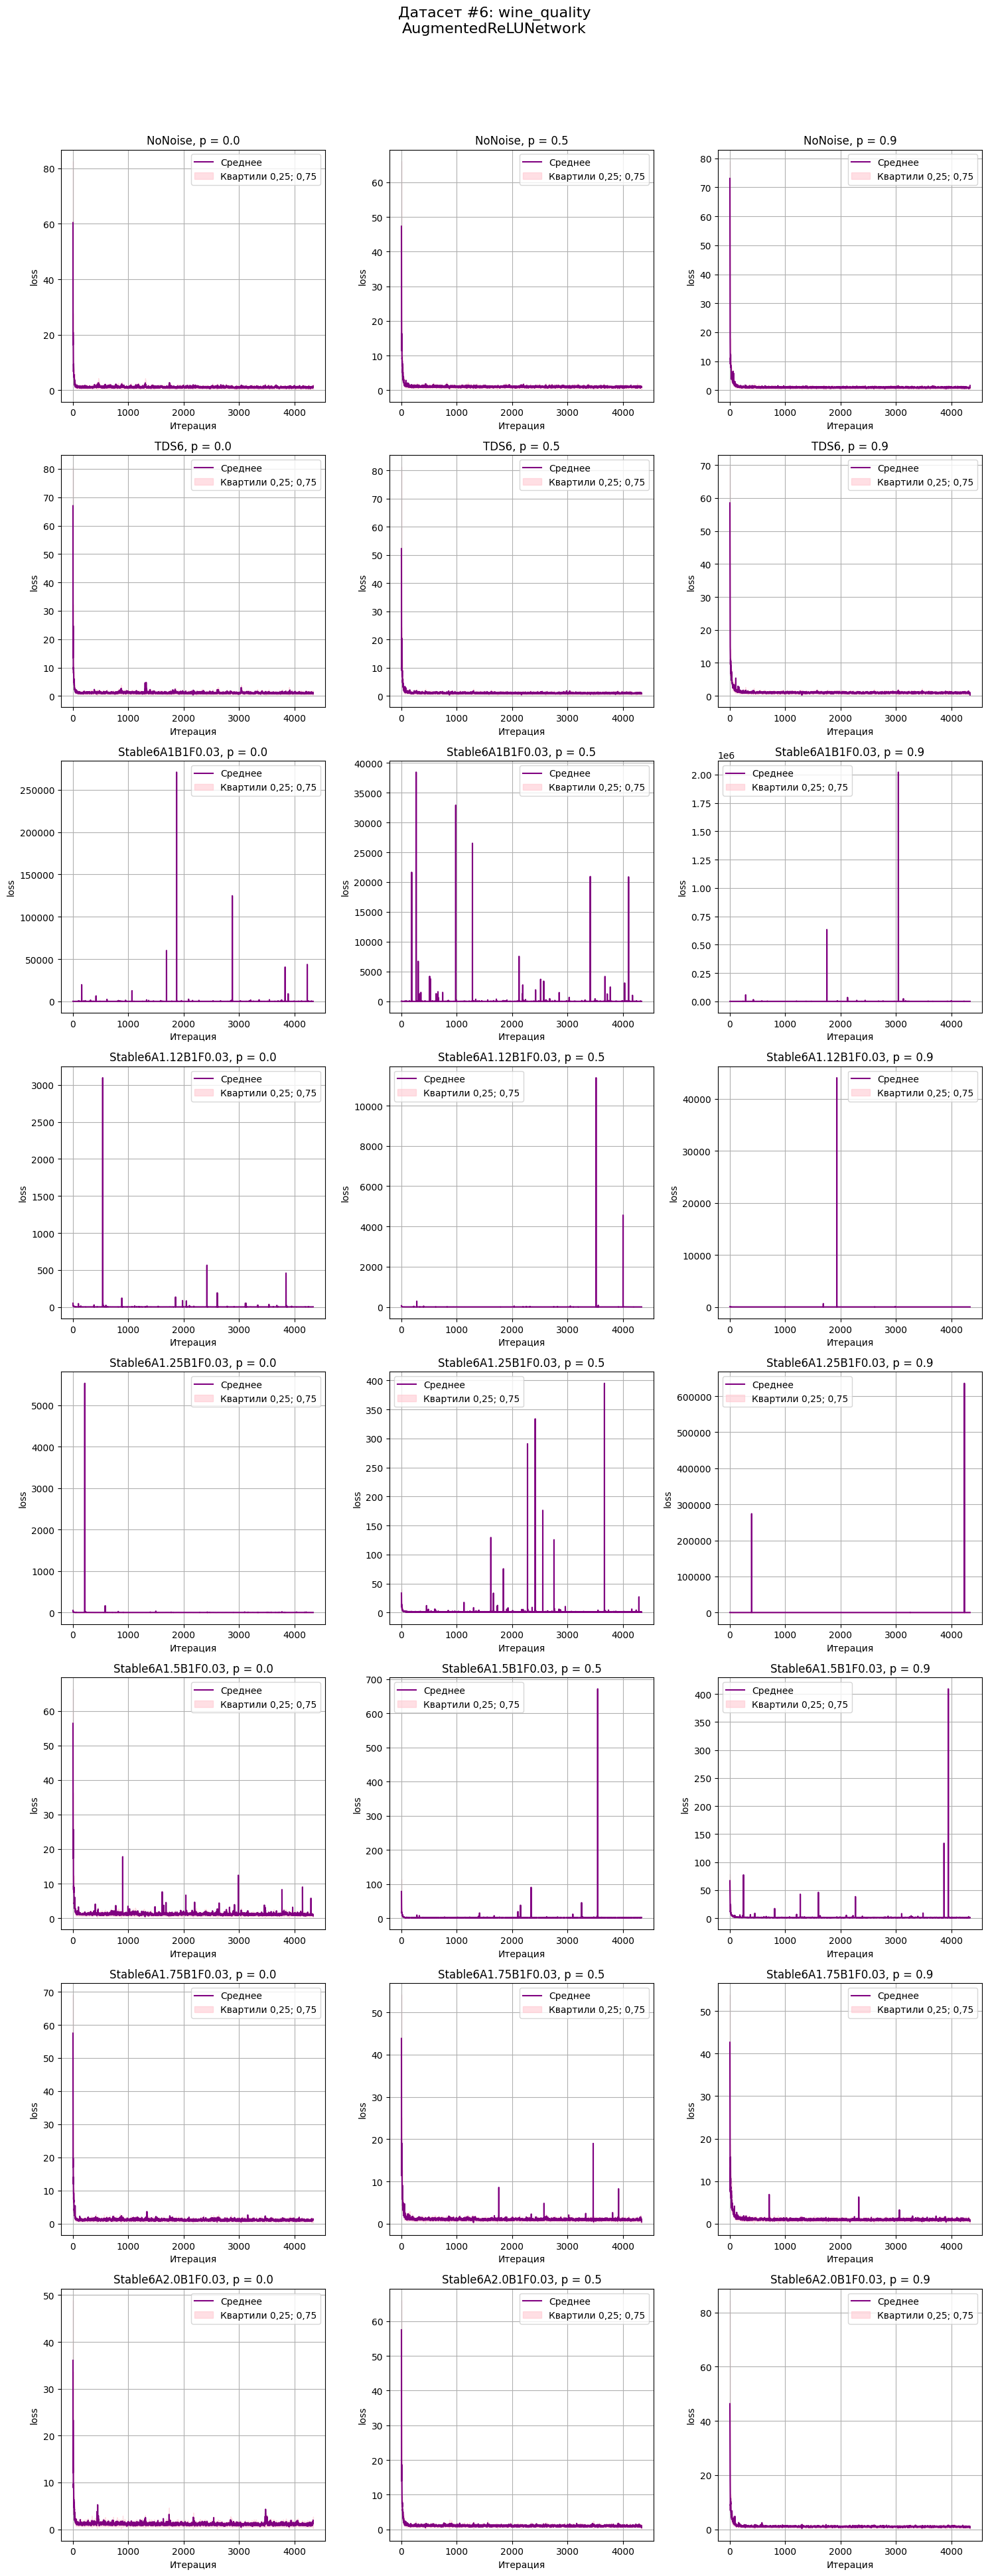

In [32]:
for i, dataset in enumerate(datasets):
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 40))

    for j in range(nrows):
        for k in range(ncols):
            ax_drawers[i][j][k](axes[j, k])

    fig.suptitle(
        f"Датасет #{dataset.number}: {dataset.name}\nAugmentedReLUNetwork", fontsize=16
    )
    plt.tight_layout(rect=[0, 0.01, 1, 0.95])  # rect adjusts space for suptitle
    plt.show()

## References

1. Chambers, J. M., Mallows, C. L., & Stuck, B. W. (1976). A method for simulating stable random variables. *Journal of the American Statistical Association*, *71*(354), 340-344.
2. M. Firouzi, A. Mohammadpour. A Survey on Simulating Stable Random Variables. URL: https://www.semanticscholar.org/reader/11a1e93642dc0a5c94e6906bcca5e4d25d4e9d46